In [239]:
import os
os.environ['STAGE'] = 'default'
import sys
sys.path.append('..')

time: 56.4 ms


In [240]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import traceback

from itertools import product
from matplotlib.ticker import ScalarFormatter
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from scipy.stats import kendalltau
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors

from job.helpers import *
from job.preprocessors import *
from job.models import *

time: 33.3 ms


In [241]:
import matplotlib as mpl
font = {
    'family' : 'Tahoma',
    'weight' : 'bold',
    'size'   : 22
}

mpl.rc('font', **font)

time: 35.9 ms


In [248]:
EXPERIMENT_DATE = pd.to_datetime(datetime.date.today())
activity_df = pd.read_pickle('data/wcp_activities_20201202-20201206_20200907-20201206.pkl')
metadata_df = pd.read_pickle('data/wcp_metadata_20201202-20201206_20200907-20201206.pkl')

time: 1.13 s


In [243]:
member_client_ids = (
    activity_df
    .client_id
    [(activity_df.event_action == 'newsletter signup')]
    .unique()
)
nonmember_client_ids = (
    activity_df
    .client_id
    [~activity_df.client_id.isin(member_client_ids)]
    .unique()
)
client_id_sample = set(member_client_ids[:3]) | set(nonmember_client_ids[:3])

sample_df = activity_df[activity_df.client_id.isin(client_id_sample)]
sample_df.to_csv('../tests/data/activities.csv', index=False)

time: 675 ms


In [244]:
# Hyperparameters derived using optimize_ga_pipeline.ipynb notebook in google-analytics-exploration
formatted_df = format_ga(
    activity_df, 
    date_list=[EXPERIMENT_DATE], 
    external_id_col='external_id',
    half_life=59.631698
)

 98% (73975 of 74923) |################# | Elapsed Time: 0:00:05 ETA:   0:00:00

time: 33.9 s


In [245]:
snapshot_df = formatted_df.reset_index()
snapshot_df = snapshot_df[snapshot_df.session_date == EXPERIMENT_DATE]
snapshot_df = snapshot_df.set_index(['client_id', 'session_date'])

time: 1.81 s


In [246]:
model = train_model(
    X=np.array(snapshot_df),
    reg=2.319952,
    n_components=130,
    epochs=2
)

 99% (2960 of 2961) |################### | Elapsed Time: 0:02:16 ETA:   0:00:00

time: 10min 49s


In [247]:
article_names = snapshot_df.columns
user_names = snapshot_df.index
article_vectors = model.item_vectors
user_vectors = model.user_vectors

time: 35.9 ms


In [258]:
metadata_df = metadata_df.reset_index().set_index('article_id')

time: 31.6 ms


pandas.core.series.Series

time: 30.2 ms


In [309]:
snapshot_df.sum().argsort()[-50:]

external_id
502684    2822
502704    2930
502739    2179
502767    1243
502776    2926
          ... 
503406    2948
503456    2952
503473    2956
503480    2943
503493    1698
Length: 50, dtype: int64

time: 1.38 s


In [321]:
np.where(snapshot_df.columns == '503353')

(array([2953]),)

time: 31.6 ms


# Something weird happened here...
https://washingtoncitypaper.com/article/241370/

https://washingtoncitypaper.com/article/275796/overkill/

In [294]:
metadata_df[metadata_df.landing_page_path == '/article/275796/overkill/']

,landing_page_path,published_at,headline,url,body
article_id,,,,,
241370,/article/275796/overkill/,2006-02-17T05:00:00+00:00,NaN,NaN,NaN


time: 36 ms


In [323]:
vector_distance = distance.cdist(article_vectors, article_vectors, metric='cosine')
vector_order = vector_distance.argsort()
for i, order in enumerate(vector_order):
    if i != 2945:
        continue
    source = metadata_df.loc[article_names[i]]
    if type(source) == pd.DataFrame:
        source = source.iloc[0]
    pd.DataFrame(source)
    for j in order[1:6]:
        article = metadata_df.loc[article_names[j]]
        if type(article) == pd.DataFrame:
            article = article.iloc[0]
        try:
            print(article.headline.strip())
            print(article.url)
        except:
            print(article.landing_page_path)

,503294
landing_page_path,/article/503294/everyone-is-suddenly-a-home-co...
published_at,2020-12-02T17:07:42+00:00
headline,Everyone Is Suddenly a Home Cook. Bold Fork Bo...
url,https://washingtoncitypaper.com/article/503294...
body,When Clementine Thomas walked into Montreal’s ...


Bub & Pop’s Lost Bub Today and Will be Closed
https://washingtoncitypaper.com/article/192760/bub-pops-lost-bub-today-and-will-be-closed/
Health Department Closes Greek Deli on 19th St. NW For Lacking ‘Easily Accessible’ Restroom
https://washingtoncitypaper.com/article/180621/health-department-closes-greek-deli-on-19th-st-nw-for-lacking-easily-accessible-restroom/
Pesce Too Pops Up Inside Bullfrog Bagels Serving Seafood on Capitol Hill
https://washingtoncitypaper.com/article/181209/pesce-too-pops-up-inside-bullfrog-bagels-serving-seafood-on-capitol-hill/
Longtime D.C. Government Watchdogs’ Property Auctioned at Tax Sale
https://washingtoncitypaper.com/article/179267/longtime-dc-government-watchdogs-property-auctioned-at-tax-sale/
Local Artists Respond to D.C.’s Comprehensive Cultural Plan
https://washingtoncitypaper.com/article/186244/local-artists-respond-to-dcs-comprehensive-cultural-plan/
time: 1.66 s


# Useful visualizations

In [135]:
clean_df = fix_dtypes(activity_df)
sorted_df = time_activities(clean_df)
filtered_df = filter_activities(sorted_df)
time_df = aggregate_time(filtered_df, date_list=[EXPERIMENT_DATE])

time: 45.9 s


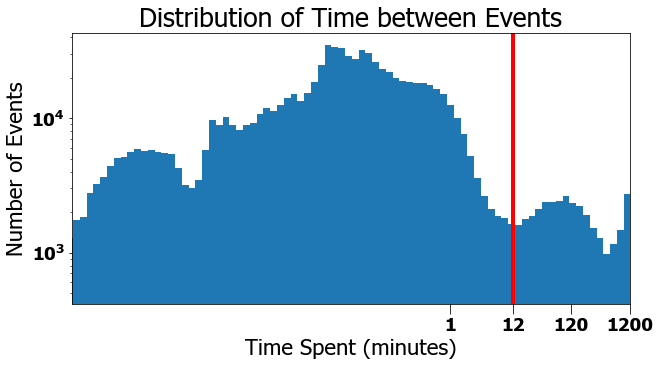

time: 542 ms


In [230]:
from matplotlib.ticker import ScalarFormatter

THRESHOLD=12

t = pd.to_timedelta(sorted_df.time_spent).dt.total_seconds().dropna() / 60
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5

fig, ax = plt.subplots(figsize=(10,5))
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
bins = ax.hist(t, bins=np.logspace(np.log(0.001),np.log(100.0), 100), log=True)
_ = plt.xscale('log')
_ = plt.axvline(x=THRESHOLD, c='red', linewidth=4)
_ = plt.xlabel("Time Spent (minutes)")
_ = plt.ylabel("Number of Events")
_ = plt.title("Distribution of Time between Events")
_ = plt.xticks([1, 12, 120, 1200])
_ = plt.xlim((x_min, 1200))
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.show()

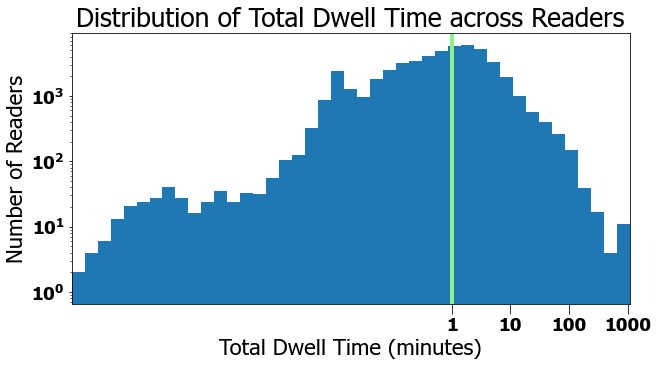

time: 630 ms


In [231]:
t = (
    pd.to_timedelta(
        filtered_df
        .groupby('client_id')['time_spent']
        .sum()
    )
    .dt.total_seconds()
    .dropna() / 60
)

THRESHOLD=1

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5

fig, ax = plt.subplots(figsize=(10,5))
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
bins = ax.hist(t, bins=np.logspace(np.log(0.001),np.log(50.0), 50), log=True)
x_min = np.sort(bins[1][np.where(bins[0] > 0)[0]])[2]
x_max = bins[1][np.where(bins[0] > 0)[0]].max()
_ = plt.axvline(x=THRESHOLD, c='lightgreen', linewidth=4)
_ = plt.xscale('log')
_ = plt.xlabel("Total Dwell Time (minutes)")
_ = plt.ylabel("Number of Readers")
_ = plt.title("Distribution of Total Dwell Time across Readers")
_ = plt.xticks([1, 10, 100, 1000])
_ = plt.xlim((x_min, x_max))
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.show()

In [214]:
article_totals = snapshot_df.sum()
reader_totals = snapshot_df.sum(axis=1)

time: 11 s


In [217]:
article_index = np.argsort(article_totals)[-2::-1]
reader_index = np.argsort(reader_totals)[-2::-1]
article_cutoff = article_totals[article_index[100]]
reader_cutoff = reader_totals[reader_index[100]]

top_articles = snapshot_df.columns[article_index]
top_articles = top_articles[article_totals[article_index] > article_cutoff]
top_readers = snapshot_df.iloc[reader_index]
top_readers = top_readers[reader_totals[reader_index] > reader_cutoff]

time: 1.71 s


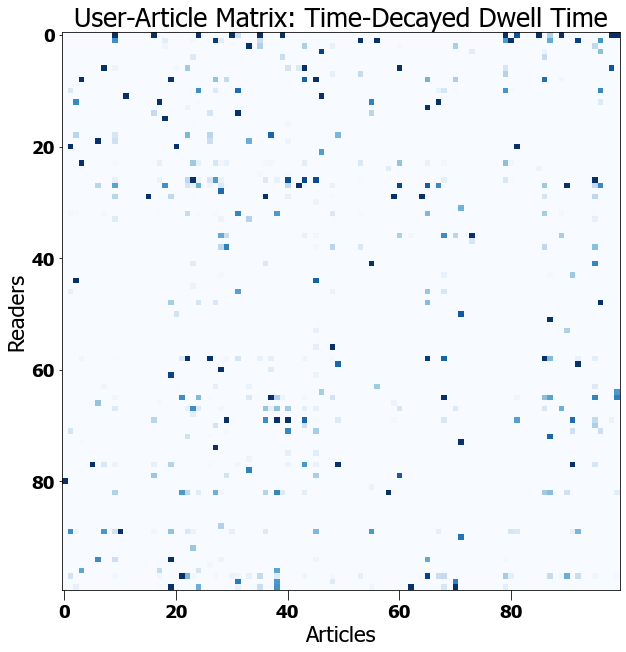

time: 247 ms


In [218]:
plot_df = top_readers[top_articles]
X = np.array(plot_df)
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)

fig, ax = plt.subplots(figsize=(10,15))
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

_ = plt.xlabel("Articles")
_ = plt.ylabel("Readers")
_ = plt.title("User-Article Matrix: Time-Decayed Dwell Time")

_ = plt.imshow(X_scaled, cmap=plt.cm.Blues)

# Boneyard

In [210]:
from sklearn.decomposition import PCA
from umap import UMAP

X = np.array(snapshot_df)
X -= X.min()
X /= X.max()

pca_model = PCA(n_components=100)
umap_model = UMAP(n_components=1)

X_100 = pca_model.fit_transform(X)
X_1 = umap_model.fit_transform(X_100)
X_1.shape

XT_100 = pca_model.fit_transform(X.T)
XT_1 = umap_model.fit_transform(XT_100)
XT_1.shape

# pca_model = PCA(n_components=1)
# umap_model = UMAP(n_components=1)

# X_1 = pca_model.fit_transform(X).reshape(-1)
# X_1 = umap_model.fit_transform(X_100)
# X_1.shape

# XT_1 = pca_model.fit_transform(X.T).reshape(-1)
# XT_1 = umap_model.fit_transform(XT_100)
# XT_1.shape

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x7fdc8cb83190>.
Failed in nopython mode pipeline (step: analyzing bytecode)
Use of unsupported opcode (IS_OP) found

File "../env/lib/python3.9/site-packages/umap/nndescent.py", line 38:
def init_rp_tree(data, dist, current_graph, leaf_array, tried=None):
    if tried is None:
    ^

During: resolving callee type: type(CPUDispatcher(<function init_rp_tree at 0x7fe6faaa3040>))
During: typing of call at /Users/ericbolton/Code/article-rec-training-job/env/lib/python3.9/site-packages/umap/nndescent.py (199)

Enable logging at debug level for details.

File "../env/lib/python3.9/site-packages/umap/nndescent.py", line 199:
def nn_descent(
    <source elided>
    if rp_tree_init:
        init_rp_tree(data, dist, current_graph, leaf_array, tried=tried)
        ^


time: 23.9 s


In [ ]:
best = 0
for label in set(user_labels):
    val = snapshot_df.loc[user_labels == label,:].sum(axis=1).mean()
    if val > best:
        best = val
        label_one = label
print(label_one)
    
print('--')
best = 0
for label in set(article_labels):
    if sum(article_labels == label) < 2:
        continue
    val = snapshot_df[snapshot_df.columns[article_labels == label]].sum().mean()
    if val > best:
        best = val
        label_two = label
        
print(label_two)
    

In [ ]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=16)
kmeans_model.fit(X_100)
user_labels = kmeans_model.labels_

In [ ]:
order = np.argsort(X_1)
index = user_labels == label_one
user_label_df = snapshot_df.iloc[order]
user_label_df = user_label_df.iloc[index[order]]

In [ ]:
# kmeans_model.fit(XT_100)
# article_labels = kmeans_model.labels_
# for label_two in set(article_labels):
order = np.argsort(XT_1)
index = article_labels == label_two
cols = user_label_df.columns[order][index[order]]
label_df = user_label_df[cols]
plot_label_df(label_df)
plt.show()

In [ ]:
np.argsort(X)

In [183]:
X_scaled[X_scaled > 0]

array([4.21e-03, 1.64e-01, 1.36e-04, 2.29e-03, 2.93e-03, 2.22e-01,
       1.02e-02, 9.93e-02, 5.91e-01, 3.67e-01, 6.33e-01, 1.85e-01,
       3.61e-03, 1.00e+00, 1.00e+00, 4.79e-03, 1.00e+00, 1.09e-01,
       1.00e+00, 2.06e-01, 1.00e+00, 3.13e-01, 1.00e+00, 2.65e-02,
       5.86e-01, 2.73e-01, 1.39e-01, 2.75e-01, 4.09e-01, 1.55e-01,
       1.64e-01, 3.11e-03, 4.90e-01, 1.00e+00, 8.77e-01, 1.00e+00,
       6.92e-01, 2.75e-02, 5.23e-02, 1.39e-02, 2.80e-02, 5.80e-01,
       1.13e-01, 1.00e+00, 1.00e+00, 5.44e-01, 2.10e-02, 2.28e-01,
       1.05e-01, 3.47e-01, 1.00e+00, 1.71e-01, 9.69e-02, 3.70e-03,
       1.00e+00, 1.00e+00, 2.21e-01, 3.52e-01, 4.98e-02, 1.89e-01,
       7.94e-02, 6.47e-02, 3.25e-02, 5.52e-03, 5.43e-03, 4.15e-03,
       7.41e-01, 3.13e-01, 4.78e-01, 6.48e-01, 1.53e-01, 4.40e-03,
       1.00e+00, 1.21e-02, 3.85e-02, 4.48e-01, 2.03e-01, 4.29e-01,
       2.44e-01, 7.55e-01, 4.71e-01, 4.43e-01, 4.43e-01, 4.83e-02,
       1.00e+00, 2.53e-01, 2.04e-02, 1.00e+00, 3.07e-03, 6.53e

time: 63.2 ms


In [164]:
def plot_label_df(label_df):
    X = np.array(label_df)
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)

    fig, ax = plt.subplots(figsize=(20,30))
    matplotlib.rcParams['xtick.major.size'] = 10
    matplotlib.rcParams['xtick.minor.size'] = 5
    plt.rc('xtick', labelsize='small')
    plt.rc('ytick', labelsize='small')

    _ = plt.xlabel("Articles")
    _ = plt.ylabel("Readers")
    _ = plt.title("User-Article Matrix: Time-Decayed Dwell Time")

    plt.imshow(X_scaled, cmap=plt.cm.Blues)

time: 26.4 ms
